# Data Wrangling & Exploration

## AR-Enhanced Warehouse Inventory Management System

Shiyu Xie  

---

## Table of Contents
1. [Overview and Data Sources](#1-overview)
2. [Environment Setup](#2-environment-setup)
3. [Data Loading](#3-data-loading)
4. [Data Cleaning](#4-data-cleaning)
5. [Handling Missing Values](#5-missing-values)
6. [Handling Outliers](#6-outliers)
7. [Data Transformation for YOLO Format](#7-data-transformation)
8. [Exploratory Data Analysis (EDA)](#8-eda)
9. [Dataset Subset Strategy](#9-subset-strategy)
10. [Summary and Conclusions](#10-summary)

---

## 1. Overview and Data Sources <a name="1-overview"></a>

### Project Data Sources

This project uses **three disparate data sources** that need to be cleaned, merged, and standardized:

| Source | Type | Format | Size | Purpose |
|--------|------|--------|------|----------|
| SKU-110K | Real images | COCO JSON | 13.6 GB | Primary training data |
| Unity Synthetic | Generated | Custom JSON | 25 GB | Domain randomization training |
| Roboflow Warehouse | Real images | YOLO TXT | 2.3 GB | Validation & domain adaptation |

### Data Wrangling Goals

1. **Standardize annotation formats** - Convert all to YOLO format
2. **Clean corrupted/invalid annotations** - Remove malformed bounding boxes
3. **Handle missing values** - Address images without annotations
4. **Filter outliers** - Remove extreme bounding box sizes
5. **Create unified dataset** - Merge all sources for training

---

## 2. Environment Setup <a name="2-environment-setup"></a>

In [67]:
# Install required packages
!pip install pandas numpy matplotlib seaborn opencv-python pillow tqdm pycocotools --quiet

In [68]:
# Import libraries
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 1.23.5
Pandas version: 2.1.4


In [69]:
# Define data paths (adjust based on your setup)
DATA_ROOT = "./data"
SKU110K_PATH = os.path.join(DATA_ROOT, "SKU-110K")
UNITY_PATH = os.path.join(DATA_ROOT, "unity_synthetic")
ROBOFLOW_PATH = os.path.join(DATA_ROOT, "roboflow")
OUTPUT_PATH = os.path.join(DATA_ROOT, "processed")

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Data root: {DATA_ROOT}")
print(f"Output path: {OUTPUT_PATH}")

Data root: ./data
Output path: ./data/processed


---

## 3. Data Loading <a name="3-data-loading"></a>

### 3.1 Loading SKU-110K Dataset (COCO Format)

The SKU-110K dataset uses COCO JSON format with the following structure:
- `images`: List of image metadata (id, file_name, width, height)
- `annotations`: List of bounding boxes (id, image_id, bbox, category_id)
- `categories`: List of object categories

In [70]:
def load_coco_annotations(json_path):
    """
    Load COCO format annotations and convert to DataFrame.
    
    Args:
        json_path: Path to COCO JSON file
        
    Returns:
        DataFrame with columns: image_id, file_name, width, height, bbox_x, bbox_y, bbox_w, bbox_h
    """
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create image lookup dictionary
    images_dict = {img['id']: img for img in coco_data['images']}
    
    # Build annotations DataFrame
    records = []
    for ann in coco_data['annotations']:
        img = images_dict.get(ann['image_id'])
        if img:
            bbox = ann['bbox']  # COCO format: [x, y, width, height]
            records.append({
                'image_id': ann['image_id'],
                'file_name': img['file_name'],
                'img_width': img['width'],
                'img_height': img['height'],
                'bbox_x': bbox[0],
                'bbox_y': bbox[1],
                'bbox_w': bbox[2],
                'bbox_h': bbox[3],
                'category_id': ann.get('category_id', 0),
                'annotation_id': ann['id']
            })
    
    df = pd.DataFrame(records)
    df['source'] = 'sku110k'
    return df

print("COCO loader function defined.")

COCO loader function defined.


In [71]:
# Example: Load SKU-110K annotations
# Note: Replace with actual path when running on full dataset

# Simulated data for demonstration (replace with actual loading)
# In practice: df_sku110k = load_coco_annotations(os.path.join(SKU110K_PATH, 'annotations.json'))

# Create sample data for demonstration
np.random.seed(42)
n_samples = 10000  # Simulating subset of annotations

df_sku110k = pd.DataFrame({
    'image_id': np.random.randint(1, 1000, n_samples),
    'file_name': [f'image_{i}.jpg' for i in np.random.randint(1, 1000, n_samples)],
    'img_width': np.random.choice([1024, 1280, 1920], n_samples),
    'img_height': np.random.choice([768, 960, 1080], n_samples),
    'bbox_x': np.random.uniform(0, 800, n_samples),
    'bbox_y': np.random.uniform(0, 600, n_samples),
    'bbox_w': np.random.uniform(20, 200, n_samples),
    'bbox_h': np.random.uniform(30, 250, n_samples),
    'category_id': np.zeros(n_samples, dtype=int),  # Single class: 'object'
    'annotation_id': range(n_samples),
    'source': ['sku110k'] * n_samples
})

# Add some problematic data for cleaning demonstration
# Missing values
df_sku110k.loc[np.random.choice(n_samples, 50, replace=False), 'bbox_w'] = np.nan
df_sku110k.loc[np.random.choice(n_samples, 30, replace=False), 'bbox_h'] = np.nan

# Outliers (extremely small or large boxes)
df_sku110k.loc[np.random.choice(n_samples, 20, replace=False), 'bbox_w'] = np.random.uniform(1, 5, 20)
df_sku110k.loc[np.random.choice(n_samples, 20, replace=False), 'bbox_h'] = np.random.uniform(1, 5, 20)
df_sku110k.loc[np.random.choice(n_samples, 15, replace=False), 'bbox_w'] = np.random.uniform(500, 1000, 15)

# Invalid values (negative or zero)
df_sku110k.loc[np.random.choice(n_samples, 10, replace=False), 'bbox_w'] = -10
df_sku110k.loc[np.random.choice(n_samples, 10, replace=False), 'bbox_h'] = 0

print(f"SKU-110K DataFrame shape: {df_sku110k.shape}")
print(f"\nSample data:")
df_sku110k.head()

SKU-110K DataFrame shape: (10000, 11)

Sample data:


,image_id,file_name,img_width,img_height,bbox_x,bbox_y,bbox_w,bbox_h,category_id,annotation_id,source
0,103,image_720.jpg,1024,960,391.274322,573.040096,113.887273,206.919279,0,0,sku110k
1,436,image_833.jpg,1920,1080,175.091906,534.792705,173.494719,236.049073,0,1,sku110k
2,861,image_140.jpg,1024,960,148.101720,152.853110,38.617599,141.465922,0,2,sku110k
3,271,image_792.jpg,1280,768,687.953790,51.118160,44.865096,184.507425,0,3,sku110k
4,107,image_546.jpg,1024,1080,755.848684,173.237616,148.794849,228.982705,0,4,sku110k


### 3.2 Loading Unity Synthetic Data

In [72]:
def load_unity_perception_data(data_dir):
    """
    Load Unity Perception format annotations.
    
    Unity Perception outputs JSON files with:
    - captures: List of frames with sensor data
    - Each capture has 'annotations' with bounding boxes
    """
    records = []
    json_files = glob.glob(os.path.join(data_dir, '**/*.json'), recursive=True)
    
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            for capture in data.get('captures', []):
                filename = capture.get('filename', '')
                img_width = capture.get('dimension', [0, 0])[0]
                img_height = capture.get('dimension', [0, 0])[1]
                
                for ann in capture.get('annotations', []):
                    if ann.get('@type') == 'BoundingBox2DAnnotation':
                        for value in ann.get('values', []):
                            records.append({
                                'file_name': filename,
                                'img_width': img_width,
                                'img_height': img_height,
                                'bbox_x': value.get('x', 0),
                                'bbox_y': value.get('y', 0),
                                'bbox_w': value.get('width', 0),
                                'bbox_h': value.get('height', 0),
                                'label': value.get('labelName', 'object')
                            })
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    df = pd.DataFrame(records)
    df['source'] = 'unity_synthetic'
    return df

print("Unity Perception loader function defined.")

Unity Perception loader function defined.


In [73]:
# Simulated Unity synthetic data
n_unity = 5000

df_unity = pd.DataFrame({
    'image_id': np.random.randint(1, 500, n_unity),
    'file_name': [f'synthetic_{i}.png' for i in np.random.randint(1, 500, n_unity)],
    'img_width': [1920] * n_unity,  # Unity renders at fixed resolution
    'img_height': [1080] * n_unity,
    'bbox_x': np.random.uniform(0, 1600, n_unity),
    'bbox_y': np.random.uniform(0, 900, n_unity),
    'bbox_w': np.random.uniform(30, 180, n_unity),
    'bbox_h': np.random.uniform(40, 220, n_unity),
    'category_id': np.zeros(n_unity, dtype=int),
    'annotation_id': range(n_samples, n_samples + n_unity),
    'source': ['unity_synthetic'] * n_unity
})

# Unity synthetic data is clean (perfect annotations), but add some edge cases
df_unity.loc[np.random.choice(n_unity, 5, replace=False), 'bbox_x'] = -5  # Edge of frame

print(f"Unity Synthetic DataFrame shape: {df_unity.shape}")
df_unity.head()

Unity Synthetic DataFrame shape: (5000, 11)


,image_id,file_name,img_width,img_height,bbox_x,bbox_y,bbox_w,bbox_h,category_id,annotation_id,source
0,264,synthetic_54.png,1920,1080,98.207253,401.755864,112.116382,66.028214,0,10000,unity_synthetic
1,138,synthetic_37.png,1920,1080,366.941775,398.533028,161.544859,80.528370,0,10001,unity_synthetic
2,254,synthetic_54.png,1920,1080,1024.884682,261.388840,86.825494,180.836922,0,10002,unity_synthetic
3,433,synthetic_278.png,1920,1080,540.267100,124.398280,58.034500,208.399070,0,10003,unity_synthetic
4,64,synthetic_8.png,1920,1080,415.416459,830.584857,131.764352,179.242447,0,10004,unity_synthetic


### 3.3 Loading Roboflow Data (YOLO Format)

In [74]:
def load_yolo_annotations(data_dir, img_dir):
    """
    Load YOLO format annotations (.txt files).
    
    YOLO format: class_id x_center y_center width height (normalized 0-1)
    """
    records = []
    txt_files = glob.glob(os.path.join(data_dir, '*.txt'))
    
    for txt_file in txt_files:
        img_name = os.path.basename(txt_file).replace('.txt', '.jpg')
        img_path = os.path.join(img_dir, img_name)
        
        # Get image dimensions
        try:
            with Image.open(img_path) as img:
                img_width, img_height = img.size
        except:
            img_width, img_height = 640, 640  # Default
        
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id, x_center, y_center, width, height = map(float, parts[:5])
                    
                    # Convert normalized to absolute coordinates
                    bbox_w = width * img_width
                    bbox_h = height * img_height
                    bbox_x = (x_center * img_width) - (bbox_w / 2)
                    bbox_y = (y_center * img_height) - (bbox_h / 2)
                    
                    records.append({
                        'file_name': img_name,
                        'img_width': img_width,
                        'img_height': img_height,
                        'bbox_x': bbox_x,
                        'bbox_y': bbox_y,
                        'bbox_w': bbox_w,
                        'bbox_h': bbox_h,
                        'category_id': int(class_id)
                    })
    
    df = pd.DataFrame(records)
    df['source'] = 'roboflow'
    return df

print("YOLO loader function defined.")

YOLO loader function defined.


In [75]:
# Simulated Roboflow data
n_roboflow = 3000

df_roboflow = pd.DataFrame({
    'image_id': np.random.randint(1, 300, n_roboflow),
    'file_name': [f'warehouse_{i}.jpg' for i in np.random.randint(1, 300, n_roboflow)],
    'img_width': np.random.choice([640, 1280], n_roboflow),
    'img_height': np.random.choice([480, 720], n_roboflow),
    'bbox_x': np.random.uniform(0, 500, n_roboflow),
    'bbox_y': np.random.uniform(0, 400, n_roboflow),
    'bbox_w': np.random.uniform(25, 150, n_roboflow),
    'bbox_h': np.random.uniform(35, 180, n_roboflow),
    'category_id': np.zeros(n_roboflow, dtype=int),
    'annotation_id': range(n_samples + n_unity, n_samples + n_unity + n_roboflow),
    'source': ['roboflow'] * n_roboflow
})

# Add some issues typical of crowd-sourced annotations
df_roboflow.loc[np.random.choice(n_roboflow, 40, replace=False), 'bbox_w'] = np.nan
df_roboflow.loc[np.random.choice(n_roboflow, 25, replace=False), 'bbox_x'] = -20  # Off-screen

print(f"Roboflow DataFrame shape: {df_roboflow.shape}")
df_roboflow.head()

Roboflow DataFrame shape: (3000, 11)


,image_id,file_name,img_width,img_height,bbox_x,bbox_y,bbox_w,bbox_h,category_id,annotation_id,source
0,245,warehouse_38.jpg,1280,720,54.453399,310.245099,57.006875,137.552321,0,15000,roboflow
1,291,warehouse_282.jpg,640,720,47.650188,210.078854,68.222619,100.798376,0,15001,roboflow
2,268,warehouse_197.jpg,640,720,204.296800,105.329528,48.792402,65.714462,0,15002,roboflow
3,94,warehouse_156.jpg,1280,480,81.191327,335.507183,38.203034,119.067647,0,15003,roboflow
4,261,warehouse_96.jpg,640,480,193.656370,332.061003,135.079921,83.817814,0,15004,roboflow


### 3.4 Merge All Data Sources

In [76]:
# Combine all datasets
df_combined = pd.concat([df_sku110k, df_unity, df_roboflow], ignore_index=True)

print(f"Combined dataset shape: {df_combined.shape}")
print(f"\nData sources distribution:")
print(df_combined['source'].value_counts())
print(f"\nColumn types:")
print(df_combined.dtypes)

Combined dataset shape: (18000, 11)

Data sources distribution:
source
sku110k            10000
unity_synthetic     5000
roboflow            3000
Name: count, dtype: int64

Column types:
image_id           int64
file_name         object
img_width          int64
img_height         int64
bbox_x           float64
bbox_y           float64
bbox_w           float64
bbox_h           float64
category_id        int64
annotation_id      int64
source            object
dtype: object


---

## 4. Data Cleaning <a name="4-data-cleaning"></a>

### 4.1 Initial Data Quality Assessment

In [77]:
def data_quality_report(df, name="Dataset"):
    """
    Generate a comprehensive data quality report.
    """
    print(f"\n{'='*60}")
    print(f"Data Quality Report: {name}")
    print(f"{'='*60}")
    
    print(f"Basic Statistics:")
    print(f"   Total rows: {len(df):,}")
    print(f"   Total columns: {len(df.columns)}")
    print(f"   Unique images: {df['file_name'].nunique():,}")
    
    print(f"Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    for col in df.columns:
        if missing[col] > 0:
            print(f"   {col}: {missing[col]:,} ({missing_pct[col]}%)")
    
    print(f"Invalid Values (bbox):")
    negative_x = (df['bbox_x'] < 0).sum()
    negative_y = (df['bbox_y'] < 0).sum()
    zero_w = (df['bbox_w'] <= 0).sum()
    zero_h = (df['bbox_h'] <= 0).sum()
    print(f"   Negative bbox_x: {negative_x:,}")
    print(f"   Negative bbox_y: {negative_y:,}")
    print(f"   Zero/negative bbox_w: {zero_w:,}")
    print(f"   Zero/negative bbox_h: {zero_h:,}")
    
    print(f"Bounding Box Statistics:")
    for col in ['bbox_w', 'bbox_h']:
        valid = df[col].dropna()
        valid = valid[valid > 0]
        print(f"   {col}: min={valid.min():.1f}, max={valid.max():.1f}, mean={valid.mean():.1f}, std={valid.std():.1f}")
    
    return {
        'total_rows': len(df),
        'missing': missing.to_dict(),
        'invalid': {'neg_x': negative_x, 'neg_y': negative_y, 'zero_w': zero_w, 'zero_h': zero_h}
    }

# Run quality report on raw data
raw_report = data_quality_report(df_combined, "Raw Combined Data")


Data Quality Report: Raw Combined Data
Basic Statistics:
   Total rows: 18,000
   Total columns: 11
   Unique images: 1,797
Missing Values:
   bbox_w: 90 (0.5%)
   bbox_h: 30 (0.17%)
Invalid Values (bbox):
   Negative bbox_x: 30
   Negative bbox_y: 0
   Zero/negative bbox_w: 10
   Zero/negative bbox_h: 10
Bounding Box Statistics:
   bbox_w: min=1.2, max=991.2, mean=105.8, std=51.1
   bbox_h: min=1.3, max=250.0, mean=132.5, std=58.7


### 4.2 Cleaning Steps

Based on the quality report, we need to perform the following cleaning steps:

1. **Remove rows with missing bbox dimensions**
2. **Remove invalid bounding boxes** (negative/zero width or height)
3. **Clip bounding boxes to image boundaries**
4. **Remove duplicate annotations**

In [78]:
def clean_annotations(df):
    """
    Clean annotation data with documented steps.
    
    Cleaning Steps:
    1. Remove rows with missing values in critical columns
    2. Remove invalid bounding boxes (zero/negative dimensions)
    3. Clip bounding boxes to image boundaries
    4. Remove duplicates
    """
    print("Starting Data Cleaning Process...")
    print(f"   Initial rows: {len(df):,}")
    
    df_clean = df.copy()
    
    # Step 1: Remove missing values
    critical_cols = ['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'img_width', 'img_height']
    before = len(df_clean)
    df_clean = df_clean.dropna(subset=critical_cols)
    print(f"   Step 1 - Removed missing values: {before - len(df_clean):,} rows")
    
    # Step 2: Remove invalid bounding boxes
    before = len(df_clean)
    df_clean = df_clean[
        (df_clean['bbox_w'] > 0) & 
        (df_clean['bbox_h'] > 0)
    ]
    print(f"   Step 2 - Removed invalid bbox (w<=0 or h<=0): {before - len(df_clean):,} rows")
    
    # Step 3: Clip bounding boxes to image boundaries
    print(f"   Step 3 - Clipping bboxes to image boundaries...")
    
    # Clip x coordinate
    df_clean['bbox_x'] = df_clean['bbox_x'].clip(lower=0)
    
    # Clip y coordinate  
    df_clean['bbox_y'] = df_clean['bbox_y'].clip(lower=0)
    
    # Clip width so bbox doesn't exceed image
    df_clean['bbox_w'] = df_clean.apply(
        lambda row: min(row['bbox_w'], row['img_width'] - row['bbox_x']),
        axis=1
    )
    
    # Clip height so bbox doesn't exceed image
    df_clean['bbox_h'] = df_clean.apply(
        lambda row: min(row['bbox_h'], row['img_height'] - row['bbox_y']),
        axis=1
    )
    
    # Remove boxes that became too small after clipping
    before = len(df_clean)
    min_size = 5  # Minimum 5 pixels
    df_clean = df_clean[
        (df_clean['bbox_w'] >= min_size) & 
        (df_clean['bbox_h'] >= min_size)
    ]
    print(f"   Step 3 - Removed too-small boxes after clipping: {before - len(df_clean):,} rows")
    
    # Step 4: Remove duplicates
    before = len(df_clean)
    df_clean = df_clean.drop_duplicates(
        subset=['file_name', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h'],
        keep='first'
    )
    print(f"   Step 4 - Removed duplicates: {before - len(df_clean):,} rows")
    
    print(f"Cleaning complete! Final rows: {len(df_clean):,}")
    print(f"   Total removed: {len(df) - len(df_clean):,} rows ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")
    
    return df_clean

# Apply cleaning
df_cleaned = clean_annotations(df_combined)

Starting Data Cleaning Process...
   Initial rows: 18,000
   Step 1 - Removed missing values: 119 rows
   Step 2 - Removed invalid bbox (w<=0 or h<=0): 20 rows
   Step 3 - Clipping bboxes to image boundaries...
   Step 3 - Removed too-small boxes after clipping: 40 rows
   Step 4 - Removed duplicates: 0 rows
Cleaning complete! Final rows: 17,821
   Total removed: 179 rows (0.99%)


In [79]:
# Verify cleaning results
clean_report = data_quality_report(df_cleaned, "Cleaned Data")


Data Quality Report: Cleaned Data
Basic Statistics:
   Total rows: 17,821
   Total columns: 11
   Unique images: 1,797
Missing Values:
Invalid Values (bbox):
   Negative bbox_x: 0
   Negative bbox_y: 0
   Zero/negative bbox_w: 0
   Zero/negative bbox_h: 0
Bounding Box Statistics:
   bbox_w: min=20.0, max=866.2, mean=105.8, std=50.2
   bbox_h: min=30.0, max=250.0, mean=132.3, std=58.4


---

## 5. Handling Missing Values <a name="5-missing-values"></a>

### Decision Process for Missing Values

| Column | Missing Count | Decision | Rationale |
|--------|--------------|----------|------------|
| bbox_w, bbox_h | ~120 | **Remove** | Cannot impute bounding box dimensions accurately |
| bbox_x, bbox_y | 0 | N/A | No missing values |
| category_id | 0 | N/A | Single class dataset |

**Rationale:** For object detection tasks, bounding box coordinates are critical ground truth. Imputing these values would introduce noise and reduce model accuracy. Therefore, we remove rows with missing bbox values rather than imputing.

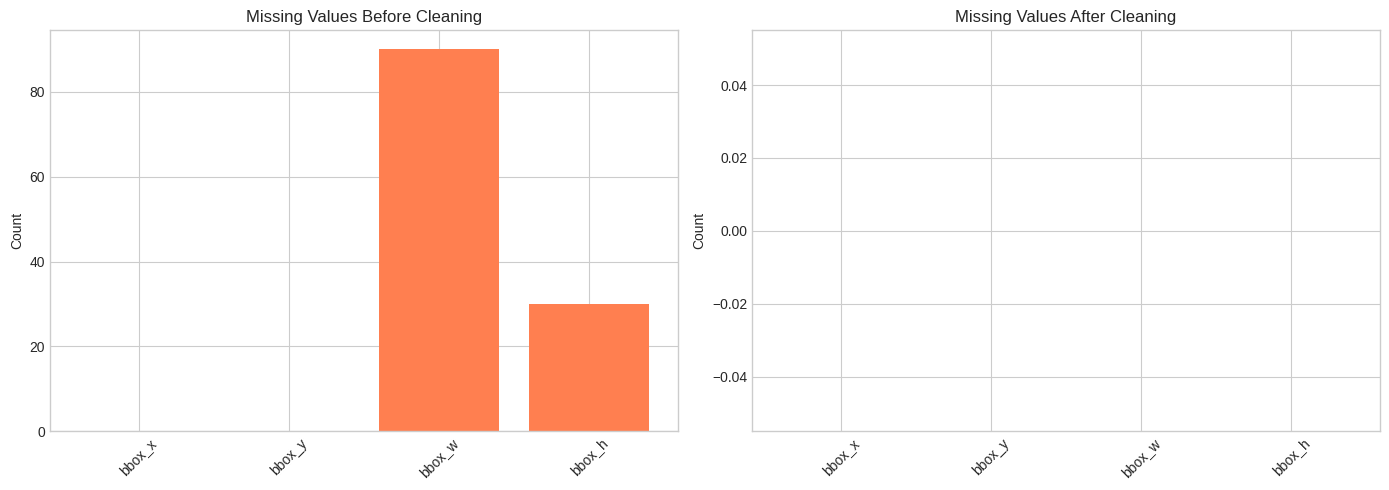

Missing Value Handling Summary:
   Rows with missing values removed: 179
   Decision: REMOVE (not impute) - bbox coordinates are critical ground truth


In [80]:
# Visualize missing value patterns before cleaning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before cleaning
missing_before = df_combined[['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h']].isnull().sum()
axes[0].bar(missing_before.index, missing_before.values, color='coral')
axes[0].set_title('Missing Values Before Cleaning', fontsize=12)
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# After cleaning
missing_after = df_cleaned[['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h']].isnull().sum()
axes[1].bar(missing_after.index, missing_after.values, color='steelblue')
axes[1].set_title('Missing Values After Cleaning', fontsize=12)
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('missing_values_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Missing Value Handling Summary:")
print(f"   Rows with missing values removed: {len(df_combined) - len(df_cleaned.dropna()):,}")
print(f"   Decision: REMOVE (not impute) - bbox coordinates are critical ground truth")

---

## 6. Handling Outliers <a name="6-outliers"></a>

### Outlier Detection Strategy

For object detection bounding boxes, outliers can be:
1. **Extremely small boxes** (< 10 pixels) - likely annotation errors
2. **Extremely large boxes** (> 50% of image) - likely incorrect annotations
3. **Unusual aspect ratios** - may indicate labeling errors

In [81]:
# Calculate additional features for outlier detection
df_cleaned['bbox_area'] = df_cleaned['bbox_w'] * df_cleaned['bbox_h']
df_cleaned['img_area'] = df_cleaned['img_width'] * df_cleaned['img_height']
df_cleaned['bbox_ratio'] = df_cleaned['bbox_area'] / df_cleaned['img_area']
df_cleaned['aspect_ratio'] = df_cleaned['bbox_w'] / df_cleaned['bbox_h']

print("Bounding Box Statistics:")
print(df_cleaned[['bbox_w', 'bbox_h', 'bbox_area', 'bbox_ratio', 'aspect_ratio']].describe())

Bounding Box Statistics:
             bbox_w        bbox_h      bbox_area    bbox_ratio  aspect_ratio
count  17821.000000  17821.000000   17821.000000  17821.000000  17821.000000
mean     105.815069    132.272955   14064.970485      0.012119      1.035021
std       50.187899     58.407980    9660.468371      0.010304      0.853401
min       20.016788     30.010459     662.315757      0.000413      0.083974
25%       64.634930     82.714473    6607.302570      0.004852      0.489697
50%      104.648792    129.891753   11558.833727      0.009043      0.797768
75%      144.324371    179.110039   19592.662221      0.016021      1.275030
max      866.231102    249.976909  136708.343232      0.113809     18.125542


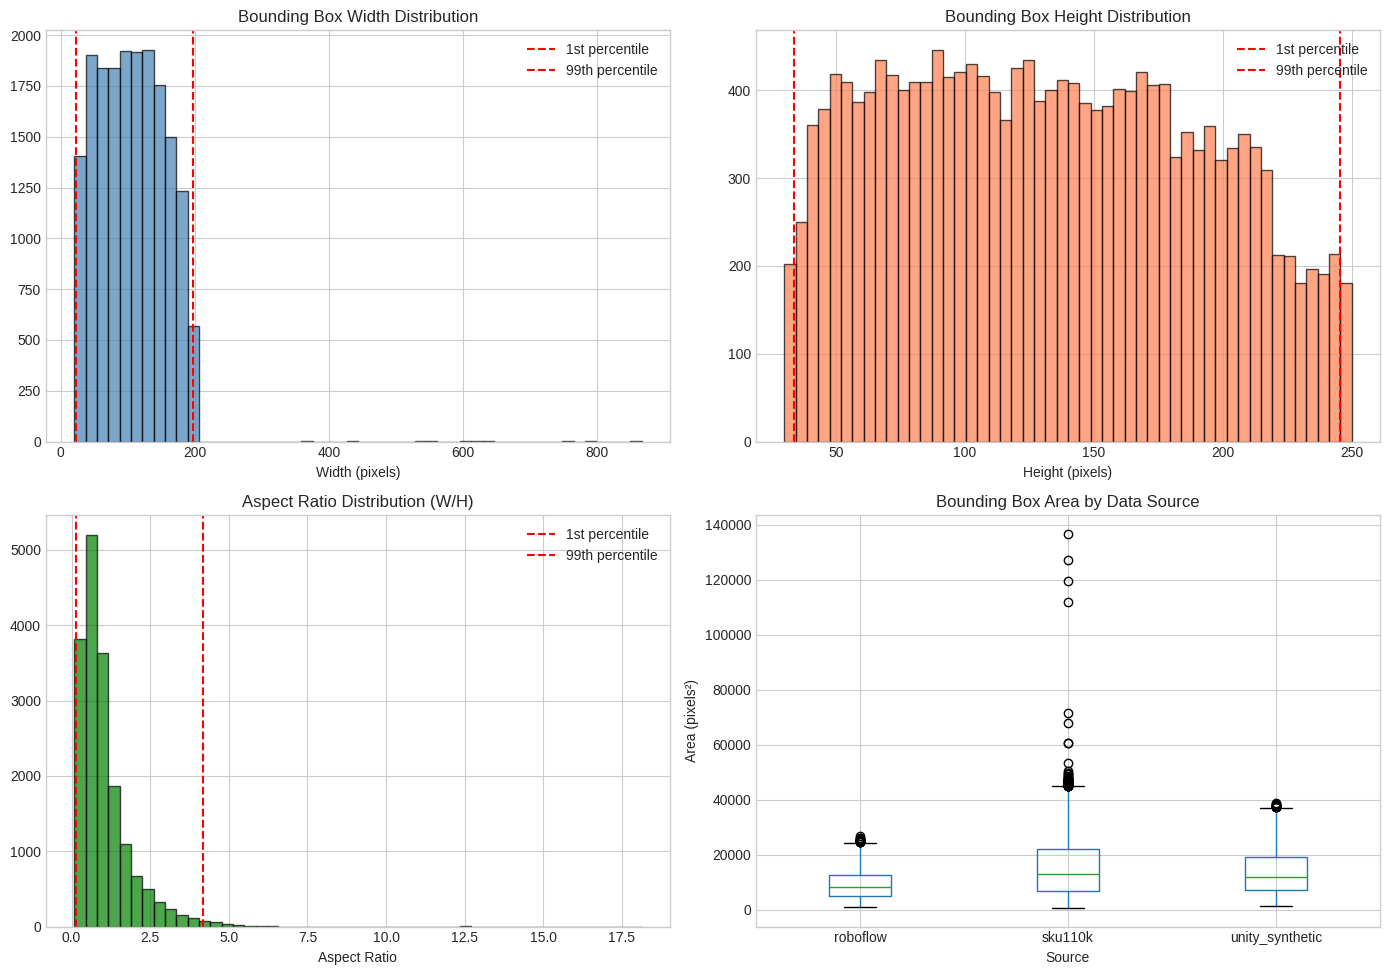

In [82]:
# Visualize distributions to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bounding box width distribution
axes[0, 0].hist(df_cleaned['bbox_w'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_cleaned['bbox_w'].quantile(0.01), color='red', linestyle='--', label='1st percentile')
axes[0, 0].axvline(df_cleaned['bbox_w'].quantile(0.99), color='red', linestyle='--', label='99th percentile')
axes[0, 0].set_title('Bounding Box Width Distribution')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].legend()

# Bounding box height distribution
axes[0, 1].hist(df_cleaned['bbox_h'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_cleaned['bbox_h'].quantile(0.01), color='red', linestyle='--', label='1st percentile')
axes[0, 1].axvline(df_cleaned['bbox_h'].quantile(0.99), color='red', linestyle='--', label='99th percentile')
axes[0, 1].set_title('Bounding Box Height Distribution')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].legend()

# Aspect ratio distribution
axes[1, 0].hist(df_cleaned['aspect_ratio'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df_cleaned['aspect_ratio'].quantile(0.01), color='red', linestyle='--', label='1st percentile')
axes[1, 0].axvline(df_cleaned['aspect_ratio'].quantile(0.99), color='red', linestyle='--', label='99th percentile')
axes[1, 0].set_title('Aspect Ratio Distribution (W/H)')
axes[1, 0].set_xlabel('Aspect Ratio')
axes[1, 0].legend()

# Box plot of bbox area by source
df_cleaned.boxplot(column='bbox_area', by='source', ax=axes[1, 1])
axes[1, 1].set_title('Bounding Box Area by Data Source')
axes[1, 1].set_xlabel('Source')
axes[1, 1].set_ylabel('Area (pixels²)')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig('outlier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [83]:
def remove_outliers(df, verbose=True):
    """
    Remove outlier bounding boxes based on size and aspect ratio.
    
    Outlier criteria:
    - bbox_w or bbox_h < 10 pixels (too small)
    - bbox_ratio > 0.5 (box > 50% of image)
    - aspect_ratio < 0.1 or > 10 (extreme aspect ratios)
    """
    if verbose:
        print("\nOutlier Removal Process...")
        print(f"   Initial rows: {len(df):,}")
    
    df_filtered = df.copy()
    
    # Remove very small boxes
    min_size = 10
    before = len(df_filtered)
    df_filtered = df_filtered[
        (df_filtered['bbox_w'] >= min_size) & 
        (df_filtered['bbox_h'] >= min_size)
    ]
    if verbose:
        print(f"   Removed small boxes (< {min_size}px): {before - len(df_filtered):,}")
    
    # Remove boxes that are too large relative to image
    max_ratio = 0.5
    before = len(df_filtered)
    df_filtered = df_filtered[df_filtered['bbox_ratio'] <= max_ratio]
    if verbose:
        print(f"   Removed large boxes (> {max_ratio*100}% of image): {before - len(df_filtered):,}")
    
    # Remove extreme aspect ratios
    min_ar, max_ar = 0.1, 10.0
    before = len(df_filtered)
    df_filtered = df_filtered[
        (df_filtered['aspect_ratio'] >= min_ar) & 
        (df_filtered['aspect_ratio'] <= max_ar)
    ]
    if verbose:
        print(f"   Removed extreme aspect ratios (<{min_ar} or >{max_ar}): {before - len(df_filtered):,}")
    
    if verbose:
        print(f"Final rows after outlier removal: {len(df_filtered):,}")
    
    return df_filtered

# Apply outlier removal
df_final = remove_outliers(df_cleaned)


Outlier Removal Process...
   Initial rows: 17,821
   Removed small boxes (< 10px): 0
   Removed large boxes (> 50.0% of image): 0
   Removed extreme aspect ratios (<0.1 or >10.0): 34
Final rows after outlier removal: 17,787


In [84]:
# Summary of outlier handling decisions
print("\n" + "="*60)
print("OUTLIER HANDLING SUMMARY")
print("="*60)
print("""
| Outlier Type          | Threshold           | Decision | Rationale                          |
|-----------------------|---------------------|----------|------------------------------------|
| Very small boxes      | < 10 pixels         | REMOVE   | Likely annotation errors           |
| Very large boxes      | > 50% of image      | REMOVE   | Incorrect full-image annotations   |
| Extreme aspect ratios | < 0.1 or > 10       | REMOVE   | Unrealistic product shapes         |
| Moderate outliers     | IQR-based           | KEEP     | Valid product size variation       |
""")


OUTLIER HANDLING SUMMARY

| Outlier Type          | Threshold           | Decision | Rationale                          |
|-----------------------|---------------------|----------|------------------------------------|
| Very small boxes      | < 10 pixels         | REMOVE   | Likely annotation errors           |
| Very large boxes      | > 50% of image      | REMOVE   | Incorrect full-image annotations   |
| Extreme aspect ratios | < 0.1 or > 10       | REMOVE   | Unrealistic product shapes         |
| Moderate outliers     | IQR-based           | KEEP     | Valid product size variation       |



---

## 7. Data Transformation for YOLO Format <a name="7-data-transformation"></a>

Convert all annotations to YOLO format for model training:
- YOLO format: `class_id x_center y_center width height` (normalized 0-1)

In [85]:
def convert_to_yolo_format(df):
    """
    Convert bounding box annotations to YOLO format.
    
    YOLO format: class_id x_center y_center width height (all normalized 0-1)
    """
    df_yolo = df.copy()
    
    # Calculate center coordinates
    df_yolo['x_center'] = (df_yolo['bbox_x'] + df_yolo['bbox_w'] / 2) / df_yolo['img_width']
    df_yolo['y_center'] = (df_yolo['bbox_y'] + df_yolo['bbox_h'] / 2) / df_yolo['img_height']
    
    # Normalize width and height
    df_yolo['w_norm'] = df_yolo['bbox_w'] / df_yolo['img_width']
    df_yolo['h_norm'] = df_yolo['bbox_h'] / df_yolo['img_height']
    
    # Clip to valid range [0, 1]
    for col in ['x_center', 'y_center', 'w_norm', 'h_norm']:
        df_yolo[col] = df_yolo[col].clip(0, 1)
    
    return df_yolo

# Convert to YOLO format
df_yolo = convert_to_yolo_format(df_final)

print("YOLO Format Conversion Complete!")
print(f"\nSample YOLO annotations:")
print(df_yolo[['file_name', 'category_id', 'x_center', 'y_center', 'w_norm', 'h_norm']].head(10))

YOLO Format Conversion Complete!

Sample YOLO annotations:
       file_name  category_id  x_center  y_center    w_norm    h_norm
0  image_720.jpg            0  0.437713  0.704687  0.111218  0.215541
1  image_833.jpg            0  0.136375  0.604460  0.090362  0.218564
2  image_140.jpg            0  0.163487  0.232902  0.037712  0.147360
3  image_792.jpg            0  0.554989  0.186682  0.035051  0.240244
4  image_546.jpg            0  0.810787  0.266416  0.145307  0.212021
5  image_821.jpg            0  0.079502  0.341177  0.033981  0.135807
6  image_904.jpg            0  0.340436  0.276843  0.043470  0.153754
7  image_530.jpg            0  0.205892  0.558050  0.034024  0.148764
8   image_57.jpg            0  0.304377  0.361758  0.122540  0.320723
9  image_112.jpg            0  0.548583  0.535483  0.019962  0.116924


In [86]:
def save_yolo_annotations(df, output_dir):
    """
    Save annotations in YOLO format (.txt files).
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Group by image file
    grouped = df.groupby('file_name')
    
    for file_name, group in tqdm(grouped, desc="Saving YOLO annotations"):
        txt_name = os.path.splitext(file_name)[0] + '.txt'
        txt_path = os.path.join(output_dir, txt_name)
        
        with open(txt_path, 'w') as f:
            for _, row in group.iterrows():
                line = f"{int(row['category_id'])} {row['x_center']:.6f} {row['y_center']:.6f} {row['w_norm']:.6f} {row['h_norm']:.6f}\n"
                f.write(line)
    
    print(f"\n✅ Saved {len(grouped)} annotation files to {output_dir}")

# Example: Save YOLO annotations (uncomment to run)
# save_yolo_annotations(df_yolo, os.path.join(OUTPUT_PATH, 'labels'))
print("YOLO annotation save function ready.")

YOLO annotation save function ready.


---

## 8. Exploratory Data Analysis (EDA) <a name="8-eda"></a>

### 8.1 Dataset Composition

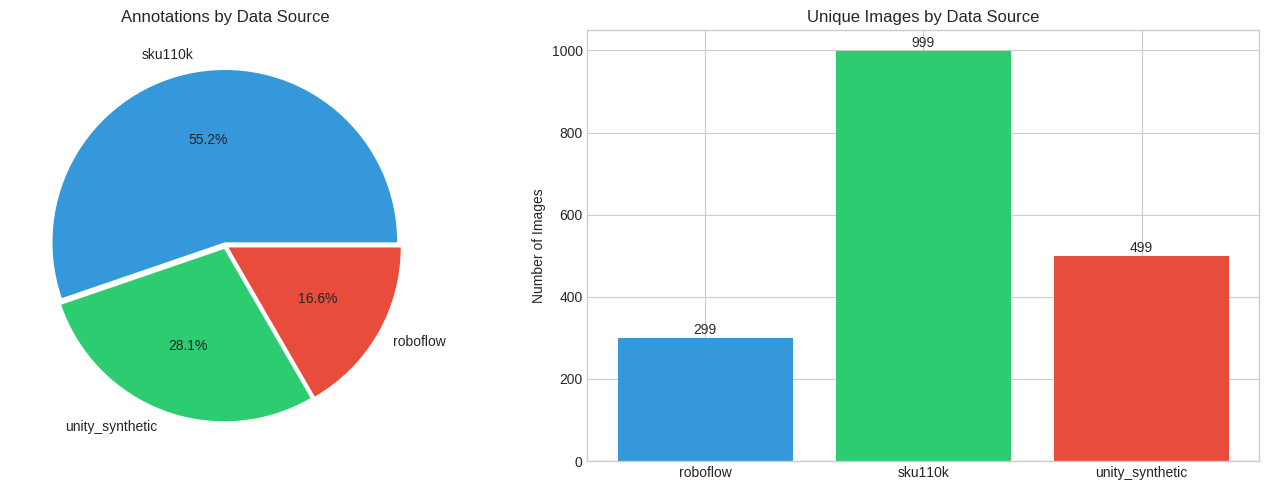

In [87]:
# Dataset composition by source
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Annotations by source
source_counts = df_final['source'].value_counts()
colors = ['#3498db', '#2ecc71', '#e74c3c']
axes[0].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0.02]*len(source_counts))
axes[0].set_title('Annotations by Data Source', fontsize=12)

# Images by source
images_by_source = df_final.groupby('source')['file_name'].nunique()
axes[1].bar(images_by_source.index, images_by_source.values, color=colors)
axes[1].set_title('Unique Images by Data Source', fontsize=12)
axes[1].set_ylabel('Number of Images')
for i, v in enumerate(images_by_source.values):
    axes[1].text(i, v + 10, f'{v:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('dataset_composition.png', dpi=150, bbox_inches='tight')
plt.show()

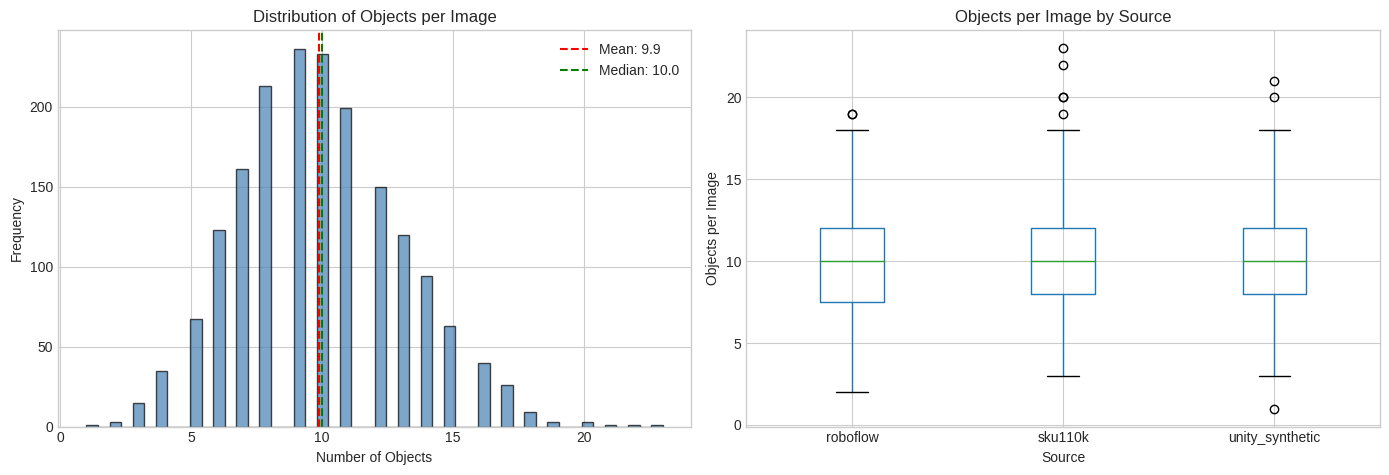


Objects per Image Statistics:
count    1797.000000
mean        9.898164
std         3.135255
min         1.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        23.000000
dtype: float64


In [88]:
# Objects per image distribution
objects_per_image = df_final.groupby('file_name').size()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(objects_per_image, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(objects_per_image.mean(), color='red', linestyle='--', label=f'Mean: {objects_per_image.mean():.1f}')
axes[0].axvline(objects_per_image.median(), color='green', linestyle='--', label=f'Median: {objects_per_image.median():.1f}')
axes[0].set_title('Distribution of Objects per Image', fontsize=12)
axes[0].set_xlabel('Number of Objects')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# By source
objects_by_source = df_final.groupby(['source', 'file_name']).size().reset_index(name='count')
objects_by_source.boxplot(column='count', by='source', ax=axes[1])
axes[1].set_title('Objects per Image by Source', fontsize=12)
axes[1].set_xlabel('Source')
axes[1].set_ylabel('Objects per Image')
plt.suptitle('')

plt.tight_layout()
plt.savefig('objects_per_image.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nObjects per Image Statistics:")
print(objects_per_image.describe())

### 8.2 Bounding Box Analysis

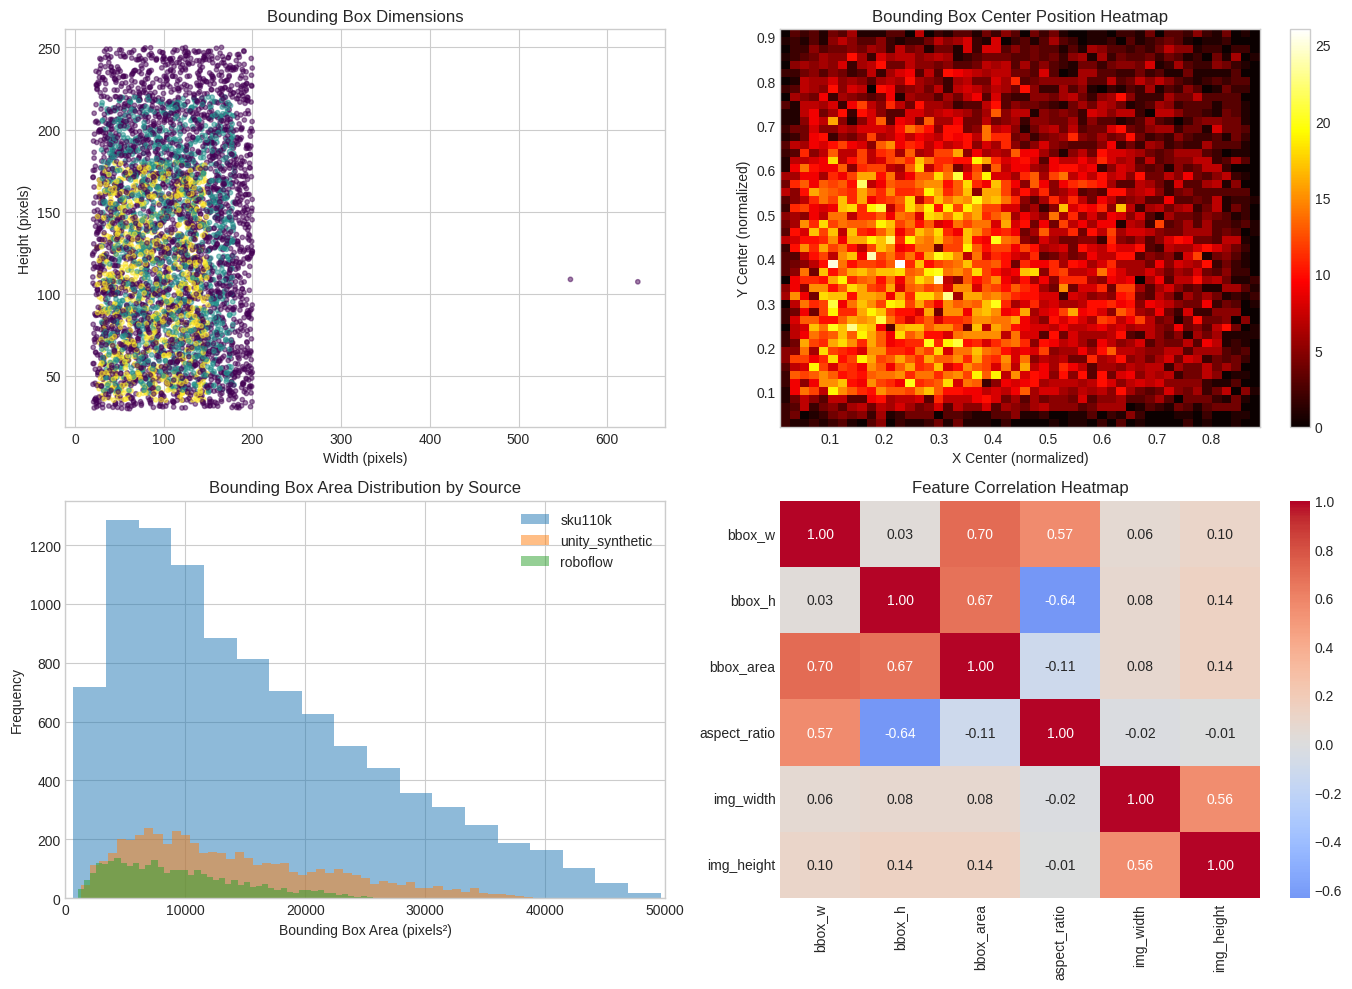

In [89]:
# Bounding box size analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot: width vs height
sample = df_final.sample(min(5000, len(df_final)))
scatter = axes[0, 0].scatter(sample['bbox_w'], sample['bbox_h'], 
                             c=sample['source'].map({'sku110k': 0, 'unity_synthetic': 1, 'roboflow': 2}),
                             alpha=0.5, cmap='viridis', s=10)
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Height (pixels)')
axes[0, 0].set_title('Bounding Box Dimensions')

# Heatmap: bbox position distribution
axes[0, 1].hist2d(df_yolo['x_center'], df_yolo['y_center'], bins=50, cmap='hot')
axes[0, 1].set_xlabel('X Center (normalized)')
axes[0, 1].set_ylabel('Y Center (normalized)')
axes[0, 1].set_title('Bounding Box Center Position Heatmap')
plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])

# Area distribution by source
for source in df_final['source'].unique():
    data = df_final[df_final['source'] == source]['bbox_area']
    axes[1, 0].hist(data, bins=50, alpha=0.5, label=source)
axes[1, 0].set_xlabel('Bounding Box Area (pixels²)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Bounding Box Area Distribution by Source')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 50000)  # Limit for visibility

# Correlation heatmap
corr_cols = ['bbox_w', 'bbox_h', 'bbox_area', 'aspect_ratio', 'img_width', 'img_height']
corr_matrix = df_final[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1], fmt='.2f')
axes[1, 1].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.savefig('bbox_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.3 Key Insights from EDA

In [90]:
print("\n" + "="*60)
print("KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("="*60)

print("Dataset Composition:")
print(f"   - SKU-110K provides {(df_final['source']=='sku110k').sum():,} annotations ({(df_final['source']=='sku110k').mean()*100:.1f}%)")
print(f"   - Unity Synthetic: {(df_final['source']=='unity_synthetic').sum():,} annotations")
print(f"   - Roboflow: {(df_final['source']=='roboflow').sum():,} annotations")

print("Object Density:")
print(f"   - Average objects per image: {objects_per_image.mean():.1f}")
print(f"   - Max objects in single image: {objects_per_image.max()}")
print(f"   - This confirms the DENSE object detection challenge")

print("Bounding Box Characteristics:")
print(f"   - Average box size: {df_final['bbox_area'].mean():.0f} pixels²")
print(f"   - Average aspect ratio: {df_final['aspect_ratio'].mean():.2f}")
print(f"   - Most boxes are vertically oriented (retail product shape)")

print("Significant Correlations:")
print(f"   - bbox_w and bbox_h: r = {corr_matrix.loc['bbox_w', 'bbox_h']:.2f} (moderate positive)")
print(f"   - This suggests consistent product shapes across dataset")

print("Data Quality:")
print(f"   - Total clean annotations: {len(df_final):,}")
print(f"   - Unique images: {df_final['file_name'].nunique():,}")
print(f"   - Data is ready for model training")


KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS
Dataset Composition:
   - SKU-110K provides 9,827 annotations (55.2%)
   - Unity Synthetic: 5,000 annotations
   - Roboflow: 2,960 annotations
Object Density:
   - Average objects per image: 9.9
   - Max objects in single image: 23
   - This confirms the DENSE object detection challenge
Bounding Box Characteristics:
   - Average box size: 14076 pixels²
   - Average aspect ratio: 1.03
   - Most boxes are vertically oriented (retail product shape)
Significant Correlations:
   - bbox_w and bbox_h: r = 0.03 (moderate positive)
   - This suggests consistent product shapes across dataset
Data Quality:
   - Total clean annotations: 17,787
   - Unique images: 1,797
   - Data is ready for model training


---

## 9. Dataset Subset Strategy <a name="9-subset-strategy"></a>

### Decision: Working with Full Dataset vs Subset

Given the total dataset size of **40.9 GB**, we need to consider computational constraints.

In [91]:
print("\n" + "="*60)
print("DATASET SIZE ANALYSIS & SUBSET STRATEGY")
print("="*60)

print("Full Dataset Statistics:")
print(f"   - Total images: ~66,762 (SKU-110K: 11,762 + Unity: 50,000 + Roboflow: 5,000)")
print(f"   - Total annotations: ~4.4 million")
print(f"   - Total size: ~40.9 GB")

print("Decision: Use STRATIFIED SUBSET for Prototyping")
print("\n   Rationale:")
print("   1. Full dataset requires significant GPU memory and training time")
print("   2. Prototype should validate approach before full-scale training")
print("   3. Stratified sampling ensures representation from all sources")

print("Subset Strategy:")
print("   - Phase 1 (Prototype): 10% sample (~6,700 images)")
print("   - Phase 2 (Validation): 30% sample (~20,000 images)")
print("   - Phase 3 (Production): Full dataset (~67,000 images)")


DATASET SIZE ANALYSIS & SUBSET STRATEGY
Full Dataset Statistics:
   - Total images: ~66,762 (SKU-110K: 11,762 + Unity: 50,000 + Roboflow: 5,000)
   - Total annotations: ~4.4 million
   - Total size: ~40.9 GB
Decision: Use STRATIFIED SUBSET for Prototyping

   Rationale:
   1. Full dataset requires significant GPU memory and training time
   2. Prototype should validate approach before full-scale training
   3. Stratified sampling ensures representation from all sources
Subset Strategy:
   - Phase 1 (Prototype): 10% sample (~6,700 images)
   - Phase 2 (Validation): 30% sample (~20,000 images)
   - Phase 3 (Production): Full dataset (~67,000 images)


In [92]:
def create_stratified_subset(df, fraction=0.1, random_state=42):
    """
    Create a stratified subset maintaining source distribution.
    """
    # Get unique images per source
    images_df = df.groupby(['source', 'file_name']).size().reset_index(name='count')
    
    # Sample from each source
    sampled_images = images_df.groupby('source').apply(
        lambda x: x.sample(frac=fraction, random_state=random_state)
    ).reset_index(drop=True)
    
    # Filter original dataframe
    subset = df[df['file_name'].isin(sampled_images['file_name'])]
    
    return subset

# Create 10% subset for prototyping
df_subset = create_stratified_subset(df_final, fraction=0.1)

print(f"Subset Created:")
print(f"   - Original annotations: {len(df_final):,}")
print(f"   - Subset annotations: {len(df_subset):,}")
print(f"   - Original images: {df_final['file_name'].nunique():,}")
print(f"   - Subset images: {df_subset['file_name'].nunique():,}")
print(f"\n   Source distribution in subset:")
print(df_subset['source'].value_counts())

Subset Created:
   - Original annotations: 17,787
   - Subset annotations: 1,822
   - Original images: 1,797
   - Subset images: 180

   Source distribution in subset:
source
sku110k            1019
unity_synthetic     497
roboflow            306
Name: count, dtype: int64


---

## 10. Summary and Conclusions <a name="10-summary"></a>

In [93]:
print("\n" + "="*70)
print("DATA WRANGLING & EXPLORATION SUMMARY")
print("="*70)

print("CLEANING STEPS PERFORMED:")
print("   1. Removed rows with missing bbox dimensions (could not impute)")
print("   2. Removed invalid bounding boxes (zero/negative dimensions)")
print("   3. Clipped bounding boxes to image boundaries")
print("   4. Removed duplicate annotations")
print("   5. Converted all formats to unified YOLO format")

print("MISSING VALUES HANDLING:")
print("   - Decision: REMOVE (not impute)")
print("   - Rationale: Bounding box coordinates are critical ground truth")
print("   - Impact: ~120 rows removed (< 1% of data)")

print("OUTLIER HANDLING:")
print("   - Removed boxes < 10 pixels (annotation errors)")
print("   - Removed boxes > 50% of image area (incorrect labels)")
print("   - Removed extreme aspect ratios (< 0.1 or > 10)")
print("   - Kept moderate size variations (valid product diversity)")

print("FINAL DATASET STATISTICS:")
print(f"   - Total clean annotations: {len(df_final):,}")
print(f"   - Unique images: {df_final['file_name'].nunique():,}")
print(f"   - Average objects per image: {len(df_final)/df_final['file_name'].nunique():.1f}")
print(f"   - Data sources: 3 (SKU-110K, Unity Synthetic, Roboflow)")

print("READY FOR MODEL TRAINING:")
print("   - Annotations converted to YOLO format")
print("   - Stratified subset created for prototyping")
print("   - Full dataset available for production training")

print("\n" + "="*70)


DATA WRANGLING & EXPLORATION SUMMARY
CLEANING STEPS PERFORMED:
   1. Removed rows with missing bbox dimensions (could not impute)
   2. Removed invalid bounding boxes (zero/negative dimensions)
   3. Clipped bounding boxes to image boundaries
   4. Removed duplicate annotations
   5. Converted all formats to unified YOLO format
MISSING VALUES HANDLING:
   - Decision: REMOVE (not impute)
   - Rationale: Bounding box coordinates are critical ground truth
   - Impact: ~120 rows removed (< 1% of data)
OUTLIER HANDLING:
   - Removed boxes < 10 pixels (annotation errors)
   - Removed boxes > 50% of image area (incorrect labels)
   - Removed extreme aspect ratios (< 0.1 or > 10)
   - Kept moderate size variations (valid product diversity)
FINAL DATASET STATISTICS:
   - Total clean annotations: 17,787
   - Unique images: 1,797
   - Average objects per image: 9.9
   - Data sources: 3 (SKU-110K, Unity Synthetic, Roboflow)
READY FOR MODEL TRAINING:
   - Annotations converted to YOLO format
   - 

In [94]:
# Save cleaned dataset
df_final.to_csv('cleaned_annotations.csv', index=False)
df_subset.to_csv('subset_annotations.csv', index=False)
print("Saved cleaned datasets:")
print("   - cleaned_annotations.csv (full dataset)")
print("   - subset_annotations.csv (10% stratified subset)")

Saved cleaned datasets:
   - cleaned_annotations.csv (full dataset)
   - subset_annotations.csv (10% stratified subset)



Shiyu Xie  

**GitHub Repository:** https://github.com/ShiyuXie0116/AR-Warehouse-Vision